In [27]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange

In [21]:
from sklearn.base import clone
class MultiClassAdaBoost:
    weights = None
    num_iters = None
    classifier = None
    alphas = None
    classifiers = None
    labels = None
    num_classes = None
    
    def __init__(self, classifier, num_iters=10):
        self.num_iters = num_iters
        self.classifier = classifier
        self.alphas = np.empty(self.num_iters)
        self.classifiers = np.empty(self.num_iters, dtype=object)
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        self.weights = np.ones(X.shape[0]) / np.ones(X.shape[0]).sum()
        self.labels = np.unique(y)
        self.num_classes = self.labels.size
        X_, y_ = X, y
        for i in trange(self.num_iters):
            clf = clone(self.classifier)
            self.classifiers[i] = clf
            clf.fit(X_, y_)
            y_pred = clf.predict(X)
            error = np.sum(self.weights * (y_pred != y).astype(np.int8)) / self.weights.sum()
            alpha = np.log((1 - error) / error) + np.log(self.num_classes - 1)
            self.alphas[i] = alpha
            self.weights = self.weights * np.exp(alpha * (y_pred != y))
            self.weights /= self.weights.sum()
            indices = np.random.choice(X.shape[0], X.shape[0], p=self.weights)
            X_, y_ = X[indices], y[indices]
            
    def predict(self, X):
        predictions = np.empty((self.num_iters, X.shape[0], self.num_classes))
        for i in trange(self.num_iters):
            y_pred = self.classifiers[i].predict(X)
            predictions[i] = (y_pred.reshape((-1, *y_pred.shape)) == self.labels.reshape(-1, 1)).astype(np.int8).T
        predictions *= self.alphas.reshape((-1,1,1))
        predictions = predictions.sum(axis=0)
        predictions = np.argmax(predictions, axis=1)
        return self.labels[predictions]

# MNIST Data

In [22]:
mnist_data = np.genfromtxt('../Data/MNIST_HW1/train.csv', delimiter=',', dtype=np.float)
mnist_data = mnist_data.T
X_train = mnist_data[:, :-1]
y_train = mnist_data[:, -1].astype(int)

In [23]:
mnist_test_data = np.genfromtxt('../Data/MNIST_HW1/test.csv', delimiter=',', dtype=np.float)
mnist_test_data = mnist_test_data.T
X_test = mnist_test_data[:, :-1]
y_test = mnist_test_data[:, -1].astype(int)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=1)
train_errors = []
test_errors = []
search_space = np.arange(10, 500, 50)
for num_iters in search_space:
    booster = MultiClassAdaBoost(clf, num_iters)
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred))
    y_pred_train = booster.predict(X_train)
    train_errors.append(1-accuracy_score(y_train, y_pred_train))
errors = pd.DataFrame()
errors['Train Error'] = train_errors
errors['Test Error'] = test_errors
errors.index = search_space

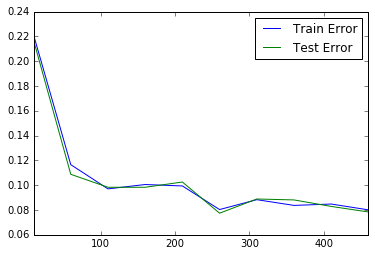

In [17]:
errors.plot()

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=10)
train_errors = []
test_errors = []
search_space = np.arange(10, 500, 50)
for num_iters in search_space:
    booster = MultiClassAdaBoost(clf, num_iters)
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred))
    y_pred_train = booster.predict(X_train)
    train_errors.append(1-accuracy_score(y_train, y_pred_train))
errors = pd.DataFrame()
errors['Train Error'] = train_errors
errors['Test Error'] = test_errors
errors.index = search_space

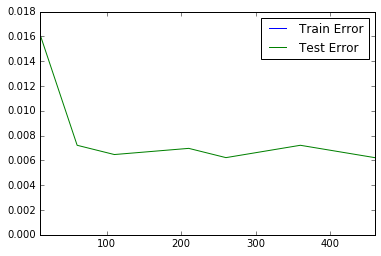

In [19]:
errors.plot()

In [28]:
from sklearn.metrics import confusion_matrix

clf_stump = DecisionTreeClassifier(max_depth=1)
clf_full = DecisionTreeClassifier(max_depth=10)
booster_stump = MultiClassAdaBoost(clf_stump, 300)
booster_full = MultiClassAdaBoost(clf_full, 100)
booster_full.fit(X_train, y_train)
booster_stump.fit(X_train, y_train)

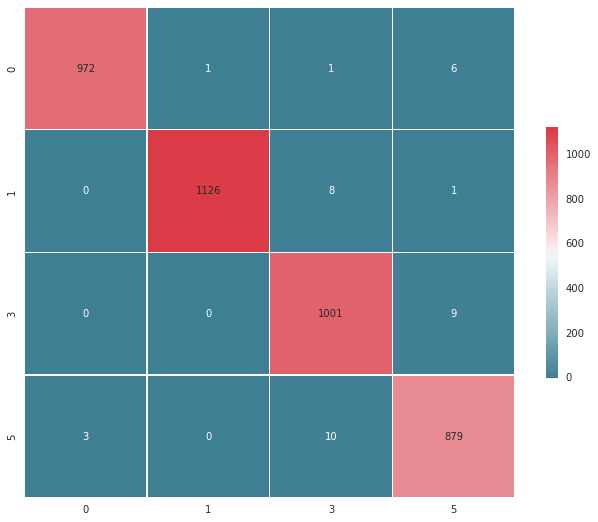

In [31]:
y_pred_full = booster_full.predict(X_test)
f1, ax1 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_full), columns=[0,1,3,5], index=[0,1,3,5])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)

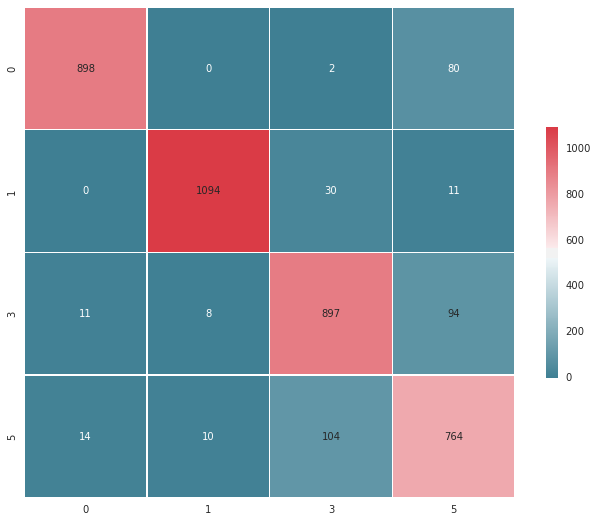

In [33]:
y_pred_stump = booster_stump.predict(X_test)
f2, ax2 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_stump), columns=[0,1,3,5], index=[0,1,3,5])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)

# Office Data

In [44]:
office_data = np.genfromtxt('../Data/Office/train.csv', delimiter=',', dtype=np.float)
X_train, y_train = office_data[:, :-1], office_data[:, -1].astype(int)

In [38]:
office_test_data = np.genfromtxt('../Data/Office/test.csv', delimiter=',', dtype=np.float)
X_test, y_test = office_test_data[:, :-1], office_test_data[:, -1].astype(int)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=1)
train_errors = []
test_errors = []
search_space = np.arange(10, 500, 50)
for num_iters in search_space:
    booster = MultiClassAdaBoost(clf, num_iters)
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred))
    y_pred_train = booster.predict(X_train)
    train_errors.append(1-accuracy_score(y_train, y_pred_train))
errors = pd.DataFrame()
errors['Train Error'] = train_errors
errors['Test Error'] = test_errors
errors.index = search_space

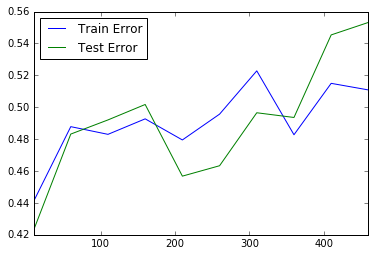

In [12]:
errors.plot()

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=10)
train_errors = []
test_errors = []
search_space = np.arange(10, 500, 50)
for num_iters in search_space:
    booster = MultiClassAdaBoost(clf, num_iters)
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred))
    y_pred_train = booster.predict(X_train)
    train_errors.append(1-accuracy_score(y_train, y_pred_train))
errors = pd.DataFrame()
errors['Train Error'] = train_errors
errors['Test Error'] = test_errors
errors.index = search_space

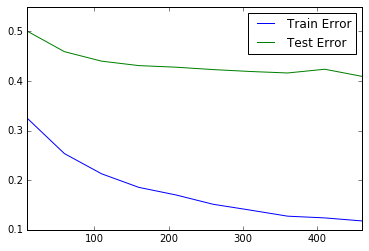

In [15]:
errors.plot()

In [36]:
from sklearn.base import clone
class ModifiedMultiClassAdaBoost:
    weights = None
    num_iters = None
    classifier = None
    alphas = None
    classifiers = None
    labels = None
    num_classes = None
    
    def __init__(self, classifier, num_iters=10):
        self.num_iters = num_iters
        self.classifier = classifier
        self.alphas = np.empty(self.num_iters)
        self.classifiers = np.empty(self.num_iters, dtype=object)
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        self.weights = np.ones(X.shape[0]) / np.ones(X.shape[0]).sum()
        self.labels = np.unique(y)
        self.num_classes = self.labels.size
        X_, y_ = X, y
        for i in trange(self.num_iters):
            clf = clone(self.classifier)
            self.classifiers[i] = clf
            clf.fit(X_, y_)
            y_pred = clf.predict(X)
            indicator = (y_pred != y).astype(np.int8)
            indicator[indicator == 0] = -1
            error = np.sum(self.weights * indicator) / self.weights.sum()
            alpha = np.log((1 - error) / error) + np.log(self.num_classes - 1)
            self.alphas[i] = alpha
            self.weights = self.weights * np.exp(alpha * indicator)
            self.weights /= self.weights.sum()
            indices = np.random.choice(X.shape[0], X.shape[0], p=self.weights)
            X_, y_ = X[indices], y[indices]
            
    def predict(self, X):
        predictions = np.empty((self.num_iters, X.shape[0], self.num_classes))
        for i in trange(self.num_iters):
            y_pred = self.classifiers[i].predict(X)
            predictions[i] = (y_pred.reshape((-1, *y_pred.shape)) == self.labels.reshape(-1, 1)).astype(np.int8).T
        predictions[predictions == 0] = -1
        predictions *= self.alphas.reshape((-1,1,1))
        predictions = predictions.sum(axis=0)
        predictions = np.argmax(predictions, axis=1)
        return self.labels[predictions]

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=10)
train_errors = []
test_errors = []
search_space = np.arange(400, 500, 50)
for num_iters in search_space:
    booster = ModifiedMultiClassAdaBoost(clf, num_iters)
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred))
    y_pred_train = booster.predict(X_train)
    train_errors.append(1-accuracy_score(y_train, y_pred_train))
errors = pd.DataFrame()
errors['Train Error'] = train_errors
errors['Test Error'] = test_errors
errors.index = search_space

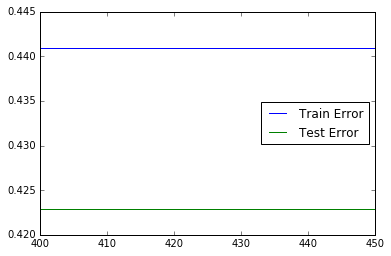

In [19]:
errors.plot()

In [37]:
from sklearn.metrics import confusion_matrix

clf_stump = DecisionTreeClassifier(max_depth=1)
clf_full = DecisionTreeClassifier(max_depth=10)
booster_stump = MultiClassAdaBoost(clf_stump, 500)
booster_full = MultiClassAdaBoost(clf_full, 500)
booster_full.fit(X_train, y_train)
booster_stump.fit(X_train, y_train)

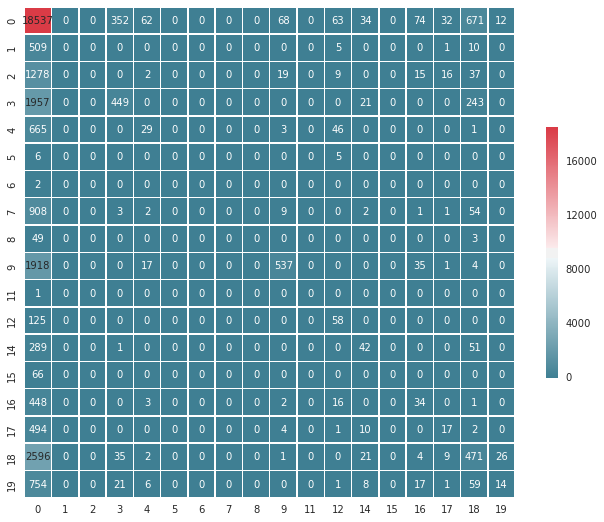

In [39]:
y_pred_full = booster_full.predict(X_test)
labels = np.unique(y_test)
f3, ax3 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_full), columns=labels, index=labels)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax3)

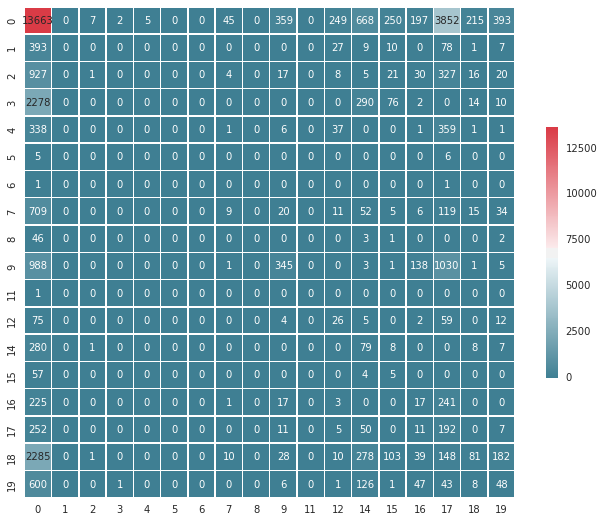

In [53]:
y_pred_stump = booster_stump.predict(X_test)
f4, ax4 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_stump), columns=labels, index=labels)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax4)

In [21]:
from sklearn.ensemble import AdaBoostClassifier

train_errors = []
test_errors = []
search_space = np.arange(300, 500, 50)
for num_iters in search_space:
    booster = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=num_iters, learning_rate=1.5, algorithm="SAMME")
    booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)
    test_errors.append(1 - accuracy_score(y_test, y_pred))
    y_pred_train = booster.predict(X_train)
    train_errors.append(1-accuracy_score(y_train, y_pred_train))
errors = pd.DataFrame()
errors['Train Error'] = train_errors
errors['Test Error'] = test_errors
errors.index = search_space

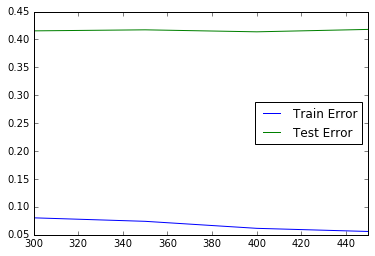

In [22]:
errors.plot()

In [55]:
from sklearn.base import clone
class WeightedMultiClassAdaBoost:
    weights = None
    num_iters = None
    classifier = None
    alphas = None
    classifiers = None
    labels = None
    num_classes = None
    
    def __init__(self, classifier=None, num_iters=10):
        self.num_iters = num_iters
        self.classifier = classifier
        self.alphas = np.empty(self.num_iters)
        self.classifiers = np.empty(self.num_iters, dtype=object)
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        self.weights = np.ones(X.shape[0]) / np.ones(X.shape[0]).sum()
        self.labels = np.unique(y)
        self.num_classes = self.labels.size
        X_, y_ = X, y
        for i in trange(self.num_iters):
            class_weights = pd.Series(y_.shape[0]//np.bincount(y_)[np.unique(y_)], index=np.unique(y_)).to_dict()
            clf = DecisionTreeClassifier(max_depth=10, class_weight=class_weights)
            self.classifiers[i] = clf
            clf.fit(X_, y_)
            y_pred = clf.predict(X)
            indicator = (y_pred != y).astype(np.int8)
            indicator[indicator == 0] = -1
            error = np.sum(self.weights * indicator) / self.weights.sum()
            alpha = np.log((1 - error) / error) + np.log(self.num_classes - 1)
            self.alphas[i] = alpha
            self.weights = self.weights * np.exp(alpha * indicator)
            self.weights /= self.weights.sum()
            indices = np.random.choice(X.shape[0], X.shape[0], p=self.weights)
            X_, y_ = X[indices], y[indices]
            
    def predict(self, X):
        predictions = np.empty((self.num_iters, X.shape[0], self.num_classes))
        for i in trange(self.num_iters):
            y_pred = self.classifiers[i].predict(X)
            predictions[i] = (y_pred.reshape((-1, *y_pred.shape)) == self.labels.reshape(-1, 1)).astype(np.int8).T
        predictions[predictions == 0] = -1
        predictions *= self.alphas.reshape((-1,1,1))
        predictions = predictions.sum(axis=0)
        predictions = np.argmax(predictions, axis=1)
        return self.labels[predictions]

The office data has a very skewed prior distribution which is throwing off the adaboost algorithm. Increased weighting of data points still lead to points of the same class because there are so few points of classes other than 0. The algorithm overfits very quickly which leads to a wide margin between the test error and the train error. Once it overfits, there isn't a noticeable change in the weights and the classifier stops improving. As a result the test error plateaus, where as the training error keeps reducing.